### Import Modules
The required modules to run the code below are the following.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import librosa
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import root_mean_squared_error
from prettytable import PrettyTable
from sklearn.metrics.pairwise import cosine_similarity

## Import Data and Inspection
The cell below is supposed to import data from "development.csv". This development dataset contains some audio features previously extracted from the recordings contained in the folder "audios_development", a collection of vocal messages from speakers of different ages. Here a brief description of each of the dataset's features:
1. **Sampling Rate:** the number of samples of the signal taken per second.
2. **Age:** age of the speaker, target attribute.
3. **Gender:** the gender of the speaker.
4. **Ethnicity:** the ethnicity of the speaker.
5. **Mean Pitch:** Mean pitch refers to the average fundamental frequency of a sound signal over a specific period.
6. **Max Pitch:** maximum fundamental frequency found in the signal.
7. **Min Pitch:** minimum fundamental frequency found in the signal 
8. **Jitter:** a measure of the variability or irregularity in the pitch of a sound signal over time.
9. **Shimmer:** Shimmer refers to the variation in the amplitude (loudness) of consecutive cycles in a sound signal.
10. **Energy:** the amount of signal power or strength over time representing the loudness or intensity of the sound.
11. **ZCR Mean:** refers to the number of times the signal changes sign (crosses zero) in a given time frame.
12. **Spectral Centroid Mean:** refers to the "center of mass" of a signal's spectrum, representing the balance point of the power distribution across different frequencies.
13. **Tempo:** refers to the rate at which spoken or sung syllables, words, or phrases are articulated.
14. **HNR:** HNR (Harmonics-to-Noise Ratio) is a measure used to assess the quality of a voice signal by comparing the amount of harmonic content (periodic components) to the amount of noise (aperiodic components).
15. **Num Words:** number of words pronounced by the speaker.
16. **Num Characters:** number of characters pronounced by the speaker.
17. **Num Pauses:** refers to the count of brief interruptions or silences between speech segments or words in a vocal audio signal.
18. **Silence Duration:** refers to the length of time a speech signal remains silent or has no vocal activity between words, syllables, or phrases. 
19. **Path:** path of the audio.

In [2]:
development = pd.read_csv("..\\Datasets\\Original Data\\development\\development.csv", index_col = 0) #import development
age = development["age"] #target attribute
paths = development["path"] #paths to recordings
development.drop(columns = ["age", "path"], inplace = True)
development["tempo"] = development["tempo"].map(lambda x : x.strip("[]")).astype(float) #stripping tempo

FileNotFoundError: [Errno 2] No such file or directory: '..\\Datasets\\Original Data\\development\\development.csv'

In order to have a deeper look at the structure of the dataset, we make use of the method "info" of Pandas in the cell that follows.

In [138]:
development.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2933 entries, 0 to 2932
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   sampling_rate           2933 non-null   int64  
 1   gender                  2933 non-null   object 
 2   ethnicity               2933 non-null   object 
 3   mean_pitch              2933 non-null   float64
 4   max_pitch               2933 non-null   float64
 5   min_pitch               2933 non-null   float64
 6   jitter                  2933 non-null   float64
 7   shimmer                 2933 non-null   float64
 8   energy                  2933 non-null   float64
 9   zcr_mean                2933 non-null   float64
 10  spectral_centroid_mean  2933 non-null   float64
 11  tempo                   2933 non-null   float64
 12  hnr                     2933 non-null   float64
 13  num_words               2933 non-null   int64  
 14  num_characters          2933 non-null   int64

The dataset is composed of 2933 rows, corresponding to the same amount of recordings and 18 attributes. The majority of the features are numerical, whereas "gender" and "ethnicity" contain object type data: we can easily get to the conclusion that those columns are made by strings. Additionally, we note that none of the attributes presents missing values. Let us have a closer look at the distribution of numerical features.

In [139]:
display(development.describe())

,sampling_rate,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
count,2933.0,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000
mean,22050.0,1189.536569,3779.570485,146.934930,0.021190,0.107741,0.005208,0.104774,2176.369847,125.085771,-74.526288,41.307535,167.936243,12.423116,13.501159
std,0.0,414.193673,532.847869,3.757917,0.006626,0.029005,0.006074,0.051646,578.925294,33.812698,38.446856,32.782431,133.816974,14.273205,10.839142
min,22050.0,346.974330,935.515560,145.349140,0.007292,0.045205,0.000028,0.015947,692.116731,51.679688,-193.693345,0.000000,0.000000,1.000000,0.668345
25%,22050.0,818.922360,3948.234400,145.419140,0.016734,0.087378,0.001960,0.060733,1740.756716,103.359375,-104.555692,4.000000,14.000000,1.000000,1.732925
50%,22050.0,1208.998300,3998.397200,145.622010,0.020525,0.104697,0.003716,0.098964,2150.814043,117.453835,-84.415550,69.000000,281.000000,8.000000,17.368526
75%,22050.0,1523.777700,3999.485400,146.820890,0.024558,0.124993,0.006338,0.139559,2566.190670,143.554688,-40.339359,69.000000,281.000000,20.000000,21.408798
max,22050.0,2724.892800,3999.792500,202.040700,0.096153,0.265167,0.129114,0.335976,4144.132595,287.109375,12.403661,69.000000,281.000000,97.000000,83.777596


Note how the sampling rate is always constant across the audios, meaning that the quality of the recordings is always the same. We can not know if this pattern is present in the evaluation set too, so we will unstack the column from the dataset leaving it stored in a separated series. Observe how minimum and maximum pitchs' distributions ranges in very narrow intervals, how energy values are close to 0, and how the only feature that assumes negative values is "hnr".

In [140]:
sampling_rate = development["sampling_rate"]
development.drop(columns = ["sampling_rate"], inplace = True)

## Data Exploration
Keeping in mind the previous insights, we now wonder how the target feature "age" is distributed across the candidates of the dataset. The cell below plots the corresponding histogram.

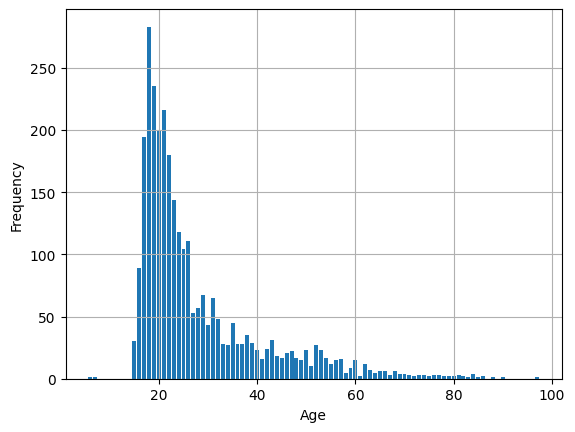

In [141]:
age_count = Counter(age)  # Counts the occurences of every age in the dataset
min_age = int(min(age_count.keys()))
max_age = int(max(age_count.keys()))
ages = np.arange(min_age, max_age+1)
frequency_list = [age_count.get(age, 0) for age in ages] #convert frequencies into a list
plt.bar(ages, frequency_list)
plt.xlabel("Age", loc='center')
plt.ylabel("Frequency", loc='center')
plt.grid()
plt.show()

The distribution is highly right-skewed, with the majority of individuals falling within the younger age range, especially between 15 and 30 years old. The frequency decreases sharply as age increases, with very few individuals above 50 years old. This suggests a youthful dataset with a steep decline in older age groups. Moreover, except for few recorded instances, the dataset contains almost no occurrences in the range 0-10. Hence, the available data are particularly unbalanced and present a strong tendency towards restricted age bonds. We must take into account this phenomena for the analysis that follow.

We are now interested in the distribution of the numerical attributes of the dataset. The snippet below plots the histograms organized in 10 bins each.

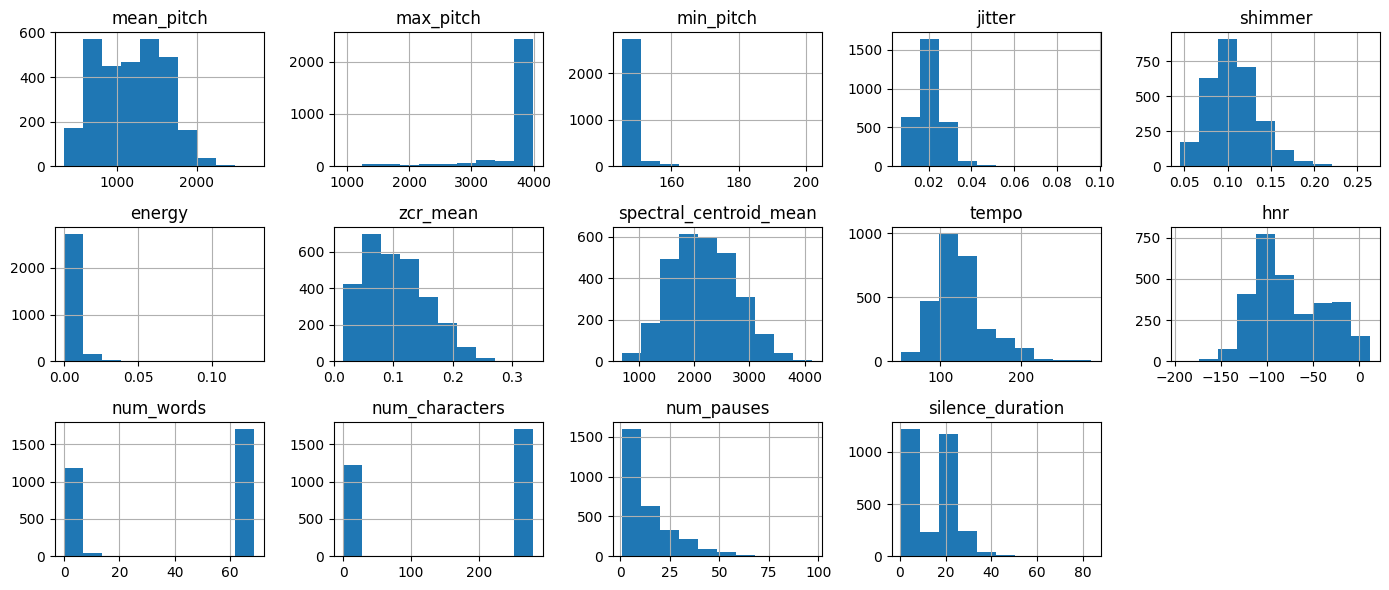

In [142]:
df = development.select_dtypes(exclude = ["object"])
fig, ax = plt.subplots(df.shape[1] // 4, 5, figsize = (14, 6))
n_bins = 10

for i in range(df.shape[1]): #plots the distribution of all the features
    row = i // 5 
    col = i - 5 * row
    bins = np.linspace(min(df.values[:, i]), max(df.values[:, i]), n_bins + 1) #defining bins of the histograms
    ax[row, col].hist(df.values[:, i], bins = bins)
    ax[row, col].grid()
    ax[row, col].set_title(df.columns[i])

ax[2, 4].set_axis_off()
plt.tight_layout()
plt.show()

The image above needs a commentary feature by feature:
1. *Mean Pitch*: presents an almost normal-shaped distribution with two peaks;
2. *Max Pitch*: present a highly left-skewed distribution, but most of the objects fall within the same bin;
3. *Min Pitch*: presents a highly right-skewed distribution, but most of the objects fall within the same bin; 
4. *Jitter*: presents a right-skewed distribution and a considerable peak on the left side;
5. *Shimmer*: Bell-shaped distribution with values clustering between 0.05 and 0.15.
6. *Energy*: presents a highly right-skewed distribution, most values close to zero;
7. *ZCR Mean*: the distribution is slightly skewed on the right, but objects are almost uniformly distributed across bins;
8. *Spectral Centroid Mean*: almost a perfect normal distribution
9. *Tempo*: Right-skewed, with most values between 50 and 150 BPM.
10. *HNR*: Skewed left, concentrated at low or negative values.
11. *Num Words*: two main bins containing the objects.
12. *Num Characters*: almost identical to previous.
13. *Num Pauses*: Right-skewed, with fewer instances of higher pauses.
14. *Silence Duration*: bimodal distribution indicating two distinct patterns.

These informations are exploited in the rest of the notebook to make some assumptions about the nature of the dataset.

**Gender Influence**

Gender can significantly influence the voice of a speaker due to physiological and anatomical differences. Men typically have longer and thicker vocal cords, resulting in lower pitch and deeper voices, while women generally have shorter and thinner vocal cords, leading to higher pitch and softer tones. 

Additionally, gendered social and cultural factors may shape vocal expression, such as pitch modulation, speech rate, and articulation style, contributing to perceptual differences between male and female voices. 
The cell below plots the histogram reporting the counters of males and females. 

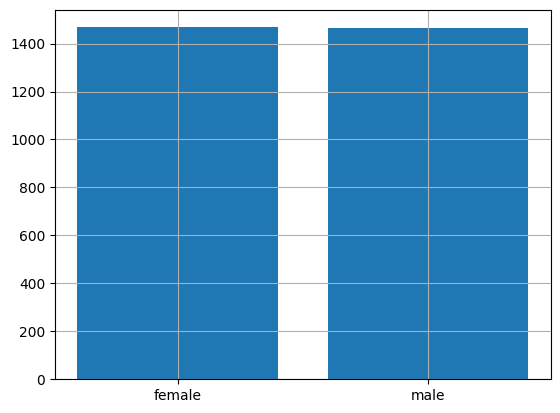

In [143]:
genders = development["gender"].value_counts()
plt.bar(np.arange(genders.index.size), genders.values)
plt.xticks(np.arange(genders.index.size), genders.index)
plt.grid()
plt.show()

Dataset seems to be perfectly split into the two genders.
Now, looking at the distribution of the mean pitch of before, we can note two peaks that may correspond to the most frequent bins within which respectively males and females fall. Let's plot them first

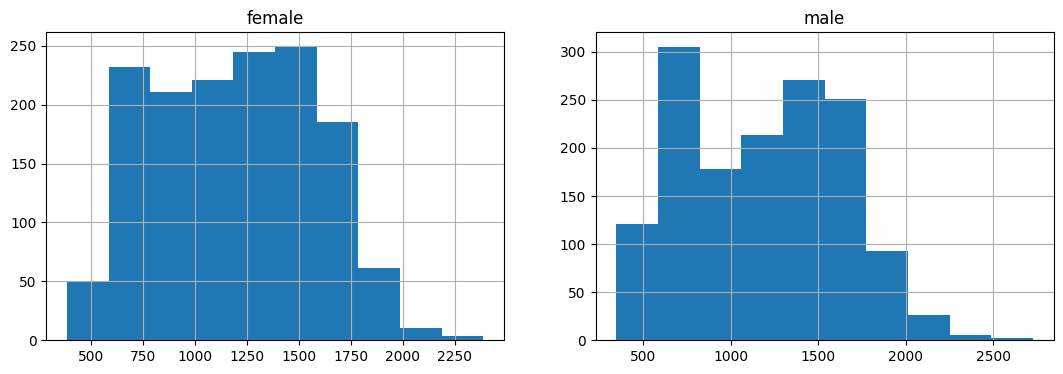

In [144]:
fig, ax = plt.subplots(1, genders.index.size, figsize = (13,4))
n_bins = 10

for i, gender in enumerate(genders.index):
    mean_pitch = development.loc[development["gender"] == gender]["mean_pitch"]
    bins = np.linspace(min(mean_pitch), max(mean_pitch), n_bins + 1)
    ax[i].hist(mean_pitch, bins = bins)
    ax[i].grid()
    ax[i].set_title(gender)
plt.show()

As expected, while females' pitch is uniformly distributed and presents a peak at 1500, males' one is more concentrated around lower values presenting its peak close to 750.
Now, can this pattern be recognized also for the minimum and the maximum pitch, too?

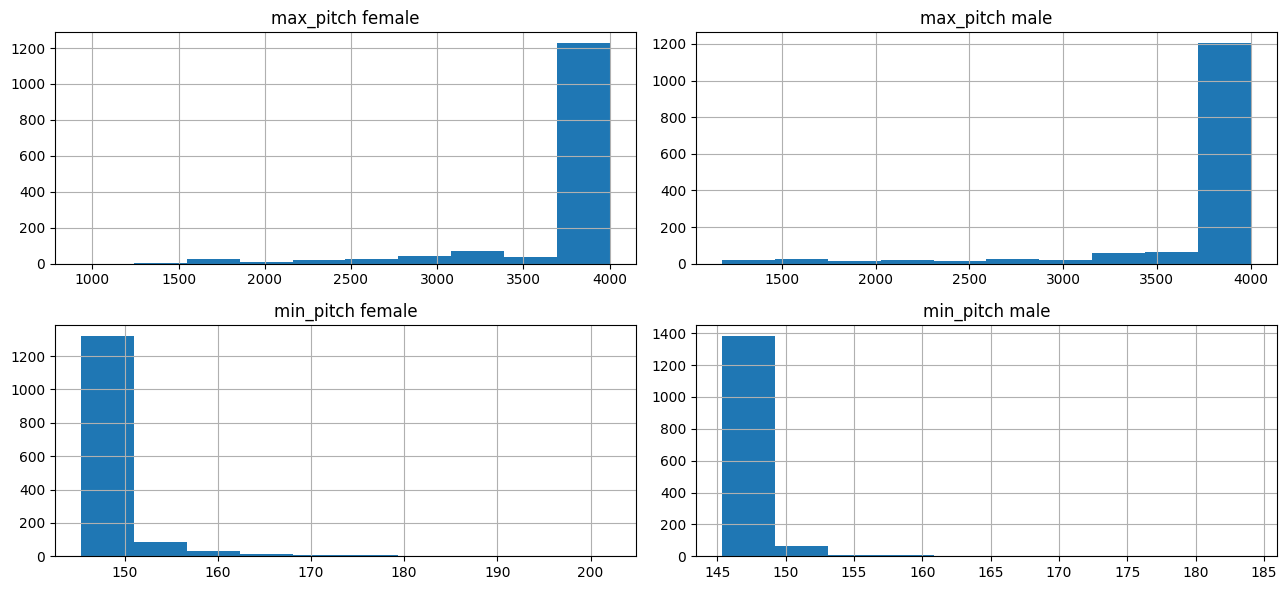

In [145]:
fig, ax = plt.subplots(2, genders.index.size, figsize = (13,6))
n_bins = 10

for i in range(4):
    row = i // 2
    col = i if i < 2 else i-2
    feat = "max_pitch" if row == 0 else "min_pitch"
    gender = "female" if col == 0 else "male"
    pitch = development.loc[development["gender"] == gender][feat]
    bins = np.linspace(min(pitch), max(pitch), n_bins + 1)
    ax[row, col].hist(pitch, bins = bins)
    ax[row, col].grid()
    ax[row, col].set_title(feat+ " " +gender)
plt.tight_layout()
plt.show()

In this case the distributions are so similar that could be considered identical:  differences are so small that cannot be perceived. Hence, it makes no sense to maintain those attributes in the dataset given that they do not contribute to distinguish speakers.
However, we should find a way to differentiate between genders in order to compare data from these categories within the same group. Indeed, it can be observed above that the influence of the gender is still relevant that cannot be entirely ignored. We could normalize each feature by the average of the corresponding gender or we can just maintain the gender attributes. We will proceed in the second way.

In [146]:
development.drop(columns = ["min_pitch", "max_pitch"], inplace = True)

**Categorical Features Encoding**

Categorical Features need to be encoded before making any kind of computation on them. Hence, the cell below is supposed to apply the one-hot encoding (preferred to the label one to avoid sorting) to the features "gender" and "ethnicity".

In [147]:
development = pd.get_dummies(development, columns = ["gender", "ethnicity"])  # Encoding the categorical attributes

**Skewed Distributions**

As noticed before, many of the features present a skewed distribution that may affect the final results of the model we are aiming to build. We can reduce this skewness by applying a logarithmic transformation: we must first ensure that no features assumes negative values and then apply log1p, namely log(1+x), element-wise to each entrance. Summing 1 prevents from having null values as arguments of the logarithms. 

We did several trials in order to see which of the distribution got more altered by the transformation (avoiding in those cases to apply it).

In [148]:
def reduce_skew(data, threshold=0.1, max_iter = 150):
    current_skewness = skew(data)
    iteration = 0
    
    while abs(current_skewness) > threshold and iteration < max_iter: # Loop until skewness is close to zero
        
        if np.any(data <= 0):  # If there are negative or zero values
            data = data + np.abs(np.min(data))  # Shift all values to positive
        
        data = np.log1p(data)  # np.log1p(x) is log(1 + x) to handle zero values
        
        current_skewness = skew(data)
        iteration += 1
        
    return data

The function above was applied to the attributes "jitter", "shimmer","energy", "num_pauses", "zcr_mean" and "tempo", obtaining the following results.

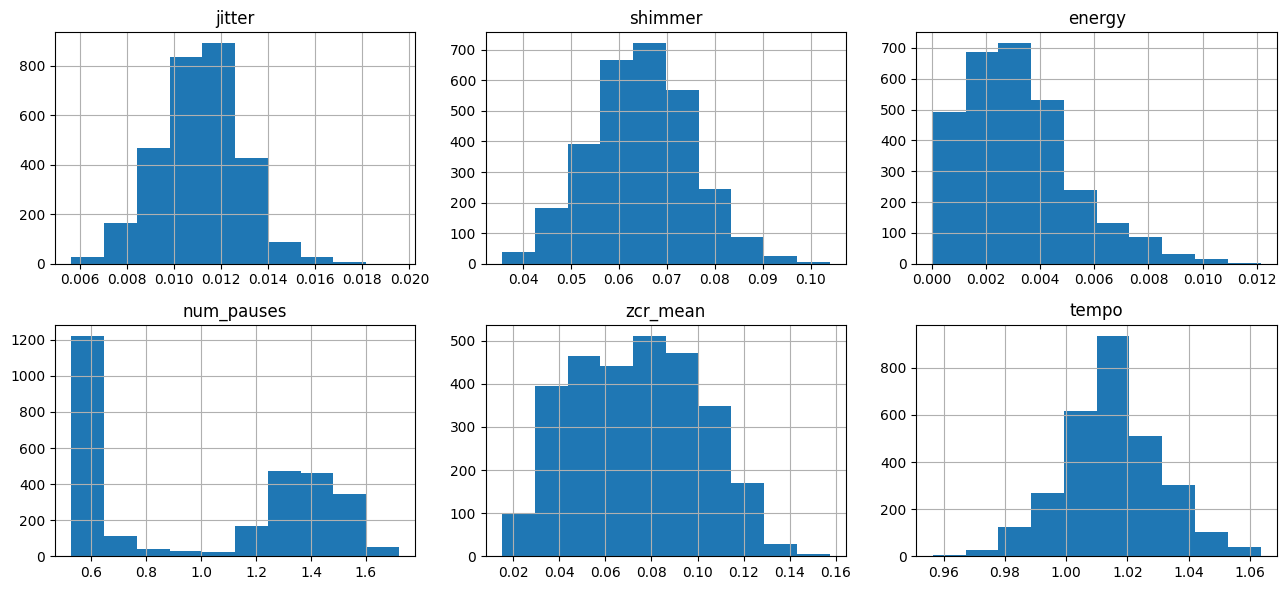

In [149]:
development["jitter"] = reduce_skew(development["jitter"])
development["shimmer"] = reduce_skew(development["shimmer"])
development["energy"] = reduce_skew(development["energy"])
development["num_pauses"] = reduce_skew(development["num_pauses"])
development["zcr_mean"] = reduce_skew(development["zcr_mean"])
development["tempo"] = reduce_skew(development["tempo"])

fig, ax = plt.subplots(2, 3,figsize = (13, 6))
for i,feat in enumerate(["jitter", "shimmer", "energy", 
                       "num_pauses", "zcr_mean", "tempo"]):
    row = i // 3
    col = i - 3 * row
    bins = np.linspace(np.min(development[feat]), np.max(development[feat]), n_bins + 1)
    ax[row, col].hist(development[feat], bins = bins)
    ax[row, col].grid()
    ax[row, col].set_title(feat)

plt.tight_layout()
plt.show()

**Content of the Audio**

The dataset presents many features related to the content of recordings and the way they are told: num_words, num_characters, num_pauses and silence_duration. 
The plots of the distribution above showed how num_words and num_characters present a similar, if not identical, distribution: this suggests us that the messages pronounced by the speakers are basically always the same two or three at most.

A manual inspection of the recordings confirm this thesis: in most of the audios, speakers asks to a third person to tell Stella to bring a list of things from a store. There are some other short messages like "I'm from Nigeria" or "I'm hungry and thirsty" scattered in the dataset. Moreover, the inspection revealed that many of the audio present num_words and num_characters equal to 0, even though someone actually speaks. We do not have the certainty but, given that most of 0-characters audio are not in English, we can suppose that something went wrong with the transcription.

Obviously, even at a first glance, it is clear how the recorded silence durations and the number of pauses made by the speakers are strictly correlated to the lengths of the spoken message. We will see later if this hypothesis will be confirmed or not.
Finally, to have an idea, let's see how many combinations (num_words, num_characters) are present in the dataset: we can assume confidently that repeated combinations correspond to the same audio message.

In [150]:
development.groupby(by = ["num_words", "num_characters"]).size()

num_words  num_characters
0          0                  409
1          2                    2
           4                    1
           5                   39
           6                    8
                             ... 
9          25                   1
           41                   1
10         25                   1
12         41                   1
69         281               1710
Length: 77, dtype: int64

The majority of audios' contents (1710) are made by 69 words and 281 characters that correspond to the message for Stella, while the remaining cases
Given the restricted pool of possible spoken messages and that it is high unlikely to find across the dataset two messages that contain the same number of words but not the same number of characters, we can state that the features "num_words" and "num_characters" basically report the same information. Hence, one of the two can be omitted from the dataset.

In [151]:
development.drop(columns = ["num_words"], inplace = True)

 Finally, "silence_duration" reports the registered silence in the audio message that depends inevitably on the total duration of the recording. Keeping this attribute invariate would be a mistake and we could run the risk of making decisions based just on the data we have without generalizing. Hence, the cell below will extract the durations of the recordings through the use of librosa that will be used later to normalize the silence duration and as a new feature of the dataset.

In [152]:
def get_durations(paths, srs):
    durations = []
    for i, path in enumerate(paths):
        y, sr = librosa.load("..\\Datasets\\Original Data\\development\\" + path, sr = srs[i]) #open audio file
        durations.append(librosa.get_duration(y = y, sr = sr)) #extract the duration
    return np.array(durations)

In [153]:
development["duration"] = get_durations(paths, sampling_rate)
development["silence_ratio"] = development["silence_duration"] / development["duration"]
development.drop(columns = ["silence_duration"], inplace = True)

This implementation will allow the model to make a fair and unbiased usage of the feature "silence_duration". 

### Feature Importance and Ethnicity

It is a good practice to run a RandomForest algorithm during the preprocessing phase in order to visualize the importances -that this model is able to compute- assigned to each of the features. Well, given that we are going to repeat this operation several times, we define in the cell below a function to reproduce this operation.

In [154]:
def evaluate_model(X, y, importances = False, rnd = 26):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True,
                                                        random_state = rnd)
    reg = RandomForestRegressor(random_state = rnd)
    sample_weights = compute_sample_weight("balanced", y = y_train)
    reg.fit(X_train, y_train, sample_weight = sample_weights)
    y_pred = reg.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)

    if importances:
        table = PrettyTable()
        table.field_names = ["Feature", "Importance"]
        sorted_features_ndx = np.argsort(reg.feature_importances_)[::-1]
        for i in sorted_features_ndx:
            table.add_row([reg.feature_names_in_[i], reg.feature_importances_[i]])
        return rmse, table

    return rmse
    

Note how we decided to manage the unbalancedness of the age distribution: before fitting the RandomForestRegressor, we compute the weights to be assigned to each sample that will be passed in input to the *fit* method, in order to give the same importance to each sample during the training of the model.

The cell below reports the outcome of the first evaluation.

In [155]:
rmse, table = evaluate_model(development, age, importances = True)
print(f"RMSE score is: {rmse}")
print(table)

RMSE score is: 10.538942898558663
+--------------------------+------------------------+
|         Feature          |       Importance       |
+--------------------------+------------------------+
|         duration         |   0.4108455885827723   |
|    ethnicity_english     |   0.0956291806293034   |
|          jitter          |  0.08129140240388631   |
|         shimmer          |  0.06298516801927954   |
|  spectral_centroid_mean  |  0.04215360683869081   |
|          energy          |  0.04141577490018273   |
|        mean_pitch        |  0.03963383587335796   |
|           hnr            |  0.03858434772315701   |
|        num_pauses        |  0.037397936544594015  |
|         zcr_mean         |  0.03438550165895157   |
|      silence_ratio       |  0.030470034583446784  |
|          tempo           |  0.021523537019727562  |
|     ethnicity_polish     |  0.01792839586697525   |
|     ethnicity_french     |  0.00732891081657921   |
|       gender_male        |  0.0056342137034839

It can be observed from the chart that the most significant feature appears to be "duration". At the bottom of the list, instead, the whole list of ethnicities is reported, each of them with a small associated importance. The only one that seems to affect the final score is the english one and the reason is clear if we observe the output of the cell below.

In [156]:
develop_ = pd.read_csv("..\\Datasets\\Original Data\\development\\development.csv", index_col = 0) #import development
develop_["1-20"] = [True if age[i] >= 1 and age[i] <= 20 else False for i in range(develop_.shape[0])]
develop_["21-40"] = [True if age[i] >= 21 and age[i] <= 40 else False for i in range(develop_.shape[0])]
develop_["41-60"] = [True if age[i] >= 41 and age[i] <= 60 else False for i in range(develop_.shape[0])]
develop_["61-100"] = [True if age[i] >= 61 and age[i] <= 100 else False for i in range(develop_.shape[0])]
develop_.groupby(by = ["ethnicity"])[["1-20", "21-40", "41-60", "61-100"]].sum().loc["english"]

1-20      113
21-40     299
41-60     116
61-100     51
Name: english, dtype: int64

Age bonds are not uniformly distributed across the ethnicities, so performing a split on ethnicity allows the random forest to narrow the feasible space a lot given that the dataset has not a balanced structure. To further confirm this thesis, let's compute the cosine similarity of the centroids of two different ethnicities that should not have nothing in common. 

In [157]:
def ethno_cosine(df, ethnicity_1, ethnicity_2):
    centroid_1 = df.loc[df["ethnicity_" + ethnicity_1] == 1].mean().values.reshape(1, -1)
    centroid_2 = df.loc[df["ethnicity_" + ethnicity_2] == 1].mean().values.reshape(1, -1)
    return cosine_similarity(centroid_1, centroid_2)[0][0]

In [158]:
ethno_cosine(development, "english", "arabic")

np.float64(0.999956726078677)

It is clear that audio features do not depend on the ethnicity of the speaker and, given that there's no correlation between the age of a person and his/her ethnicity, we can proceed by removing this biased feature.

In [159]:
for col in development.columns:
    if col.startswith("ethnicity"):
        development.drop(columns = [col], inplace = True)

Now we can run the RF again.

In [160]:
rmse, table = evaluate_model(development, age, importances = True)
print(f"RMSE score is {rmse}")
print(table)

RMSE score is 10.936080709568717
+------------------------+-----------------------+
|        Feature         |       Importance      |
+------------------------+-----------------------+
|        duration        |  0.38666373141666277  |
|         jitter         |   0.096094132481877   |
|        shimmer         |  0.09008873383803602  |
|       mean_pitch       |  0.07901969220557983  |
|          hnr           |  0.05720937944469482  |
|         energy         |  0.056540771876562784 |
| spectral_centroid_mean |  0.053268428556220486 |
|        zcr_mean        |  0.04289288398448428  |
|       num_pauses       |  0.04242904500386802  |
|     silence_ratio      |  0.03991148424965099  |
|         tempo          |  0.032939707153333914 |
|      gender_male       |  0.013360671661442412 |
|     gender_female      |  0.008114200801547126 |
|     num_characters     | 0.0014671373260395184 |
+------------------------+-----------------------+


As expected we got a decrease: the random forest is no longer able to exploit the structure of the dataset to recognize patterns.

## Audio Features

There exist several different audio features that can be extracted from a vocal message. The library librosa offers a bunch of different methods and techniques to extract those informations from a wav file. We did already extracted duration, but many other things can be still done.

After careful evaluation, we decided to extract these new features:

1. **Mel Frequency Cepstral Coefficients (MFCCs)** are a representation of audio signals that captures the perceptually relevant features of sound. They are widely used in speech and audio processing tasks like speech recognition, speaker identification, and emotion analysis.

MFCCs are derived by:

- Dividing the audio signal into short frames.

- Applying the Fourier Transform to convert the signal to the frequency domain.

- Passing the spectrum through a filter bank that mimics the human ear's perception of pitch (mel scale).

- Taking the logarithm of the filter bank energies to reflect human loudness perception.

- Applying the Discrete Cosine Transform (DCT) to decorrelate the features and retain the most important coefficients.

2. **Mel spectrogram**  is a visual representation of an audio signal's frequency content over time, mapped to the mel scale to reflect how humans perceive pitch.

To create a mel spectrogram:

- The audio signal is divided into short frames.
- A Fourier Transform is applied to compute the frequency spectrum for each frame.
- The power spectrum is passed through a filter bank aligned with the mel scale, which models the human ear's sensitivity to different frequencies.
- The result is a time-frequency representation where the frequencies are spaced according to the mel scale.

Starting from MFCCs, many studies for human speech detection make use of 13 coefficients per frame. Including more than 13 coefficients increases dimensionality without significantly improving recognition or analysis, and may even capture noise or irrelevant details.

To aggregate all of this features that depend on the number of frames in which the audio is divided, we will compute the average for each audio and the standard deviation. Then we will test those new features on a RF again.

In [163]:
def extract_mfcc(paths, n_mfcc, srs, df =  False):
    mfcc_means = []
    mfcc_stds = []
    for i, path in enumerate(paths):
        y, sr = librosa.load("..\\Datasets\\Original Data\\development\\" + path, sr = srs[i])
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfccs, axis=1)  # Mean MFCCs
        mfcc_std = np.std(mfccs, axis=1) #Std MFCCs
        mfcc_means.append(mfcc_mean)
        mfcc_stds.append(mfcc_std)
    if df:
        return pd.DataFrame(mfcc_means, columns = [f"Mfcc_{i+1}_mean" for i in range(n_mfcc)]), pd.DataFrame(mfcc_stds, columns = [f"Mfcc_{i+1}_std" for i in range(n_mfcc)])
    return np.array(mfcc_means), np.array(mfcc_stds)

In [165]:
mfccs_means, mfccs_stds = extract_mfcc(paths, n_mfcc = 13, srs = sampling_rate, df = True)
develop_ = development.copy()
mfccs = pd.concat((mfccs_means, mfccs_stds), axis = 1)
develop_ = pd.concat((develop_, mfccs), axis = 1)

Let's compute the importances of these new feature and how they impact on predictions.

In [ ]:
rmse, table = evaluate_model(develop_, age, importances = True)
print(f"RMSE score is {rmse}")
print(table)

RMSE score is 10.374397913606682
+------------------------+------------------------+
|        Feature         |       Importance       |
+------------------------+------------------------+
|        duration        |  0.32421986126738733   |
|      Mfcc_7_mean       |  0.08458629356921046   |
|         jitter         |  0.06965528224766465   |
|      Mfcc_8_mean       |  0.04882629780418203   |
|        shimmer         |  0.043645539659044545  |
|      Mfcc_9_mean       |  0.03478229917303934   |
|      Mfcc_13_mean      |  0.03460893804780669   |
|      Mfcc_5_mean       |  0.03298016174867607   |
|          hnr           |  0.03171957503483892   |
|       mean_pitch       |  0.029682264741467818  |
|         energy         |  0.028740181205145803  |
|      Mfcc_11_mean      |  0.02334091829418851   |
|      Mfcc_12_mean      |  0.02302079131900744   |
|      Mfcc_10_mean      |  0.022544944707279493  |
|      Mfcc_4_mean       |  0.018421657426751125  |
|      Mfcc_6_mean       |  0.0

The improvement in terms of RMSE is clear if compared to the previous scenario. MFCCs coefficients catch a large portion of the information related to the age of the speaker. Note how not all the mfcc give a significant contribute to the regression task, but none of them occupies the bottom of the chart: adding more coefficient would have inserted much more useless noisy features.